# __Scenario B:__<br>α-glucosidase inhibition by fucoidan

Data provided by Chantal Daub (Biochemistry, Rhodes University, Makhanda, South Africa)

## Project background
In this scenario, the inhibitory properties of fucoidan on $\alpha$-glucosidase from *Saccharomyces cerevisiae* was investigated. Fucoidan is a sulfated polysaccharide found in various brown algae. Furthermore, the polysaccaride is investigated as an potential active compound in the fields of anit-cancer, anti-inflammation, and anti-coagulate research, among others ({cite:t}`li2008fucoidan`). Recently, {cite:t}`daub2020fucoidan` proposed the application of fucoidan as a drug for the treatment of diabetes mellitus, since fucoidan effectively inhibit $\alpha$-glucosidase. In the corresponding study, fucoidan from *E. maxima* showed an almost 2-fold lower IC<sub>50</sub> value, compared to established diabetes drug acarbose.  
In the following analysis, $\alpha$-glucosidase was exposed to fucoidan from *Ecklonia maxima*, *Ecklonia radiata*, *Fucus vesiculosus*, and *Schimmelmannia elegans* to test their respective inhibition abilities.

### Experimental design 
$\alpha$-glucosidase reactions, catalyzing the hydrolysis of p-nitrophenyl glucopyranoside (p-NPG) to p-nitrophenol were conducted with and without fucoidan from each seaweed species as well as acarbose. Thereby, fucoidan was applied in two different concentrations. p-NPG was applied in a range from 0.1 mM to 5 mM, to enzyme reactions containing 9.19 µM $\alpha$-glucosidase
Product formation was recorded photometrically at 405 nm and 37°C for 20 min. Product concentrations were calculated utilizing a photometric p-NP standard. Additionally control reaction without enzyme were prepared to subtract the absorption contribution of the respective inhibitor, buffer, enzyme and substrate.


## Data preparation

### Imports and parser function

In [2]:
from typing import Dict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re
import os
import pyenzyme as pe
from CaliPytion.tools.standardcurve import StandardCurve
from EnzymePynetics.tools.parameterestimator import ParameterEstimator


import warnings
warnings.filterwarnings('ignore')

colors = list(mcolors.TABLEAU_COLORS.values())

# Parser
def measurement_data_to_EnzymeML(
    template_path: str,
    measurement_data: np.ndarray,
    species_id: str,
    time: np.ndarray,
    data_unit: str,
    time_unit: str
    ) -> pe.EnzymeMLDocument:

    enzmldoc: pe.EnzymeMLDocument = pe.EnzymeMLDocument.fromTemplate(template_path)

    for IDs, concentration in zip(enzmldoc.measurement_dict.keys(), measurement_data):
        for counter, replicate in enumerate(concentration):
            
            enzmldoc.getMeasurement(IDs).addReplicates(pe.Replicate(
                id=f"Measurement{counter}",
                species_id=species_id,
                data=list(replicate),
                data_unit=data_unit,
                time=list(time),
                time_unit=time_unit), enzmldoc)

    return enzmldoc

# Ignore hidden files in file stystem
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

Measurement data was provided as an excel file, whereas metadata was filled in EnzymeML Excel templates for each fucoidan seaweed species and acarbose respectively. In preliminary experiments, p-NPG showed to  absorb at the product detection wavelength slightly. Therefore, the absorbance contribution of substrate at the product absorption wavelength was subtracted as well as the the contributions of enzyme, buffer and inhibitor. Then, the blanked absorbance data was written to the EnzymeML documents by a parser function.

In [3]:
dataset_path = "../../data/glucosidase_inhibition/experimental_data_real.xlsx"
template_directory = "../../data/glucosidase_inhibition/EnzymeML_templates"   

enzml_docs = []
# Load experimental data from Excel
excel_sheets = sorted(pd.ExcelFile(dataset_path).sheet_names)
inhibitors = excel_sheets[:-1]
substrate_controls = excel_sheets[-1]
initial_substrates = [0.1, 0.25, 0.5, 1, 2.5, 5] # mM

# Blank data
## Absorption contribution from substrate
substrate_absorption_data = pd.read_excel(dataset_path, sheet_name=substrate_controls).set_index("time")
buffer_enzyme_absorption = np.mean(substrate_absorption_data.iloc[:,0])
substrate_absorptions = substrate_absorption_data.subtract(buffer_enzyme_absorption).drop(columns=["Buffer+ Enzyme"])
substrate_absorptions = substrate_absorptions.values.T.reshape(2,6,21)
substrate_absorptions = np.mean(substrate_absorptions, axis=0)
substrate_absorptions = np.mean(substrate_absorptions, axis=1)
mapper_substrate_enzyme_absorption = dict(zip(initial_substrates, substrate_absorptions))

for inhibitor, template in zip(sorted(inhibitors), sorted(listdir_nohidden(template_directory))):
    df = pd.read_excel(dataset_path, sheet_name=inhibitor).set_index("time")
    time = df.index.values
    inhibitor_controls = df.iloc[:,:4]
    inhibitor_concs = np.unique([float(conc.split(" ")[-2]) for conc in inhibitor_controls.columns])
    inhibitor_absorptions = inhibitor_controls.values.T.reshape(2,2,21)
    inhibitor_absorptions = np.mean(inhibitor_absorptions, axis=1)
    inhibitor_absorptions = np.mean(inhibitor_absorptions, axis=1)
    mapper_inhibitor_absorption = dict(zip(inhibitor_concs, inhibitor_absorptions))
    mapper_inhibitor_absorption[0.0] = buffer_enzyme_absorption
    df = df.iloc[:,4:]
    for column in df.columns:
        init_substrate = float(column.split(" ")[4])
        inhibitor_conc = float(column.split(" ")[1])
        df[column] = df[column] - mapper_substrate_enzyme_absorption[init_substrate] 
        df[column] = df[column] - mapper_inhibitor_absorption[inhibitor_conc]
    
    data = df.values.T.reshape(3,2,6,21)
    data = np.moveaxis(data,1,2).reshape(18,2,21)

    # Parse measurement data to EnzymeML documents
    enzml_docs.append(measurement_data_to_EnzymeML(
        template_path=f"{template_directory}/{template}",
        measurement_data=data,
        time=time,
        species_id="s1",
        data_unit="mmole / l",
        time_unit="min"
    ))

### Data quality

In the next cell, the blanked absorption data of each EnzymeML document is visualized with the ```.visualize()```-method of PyEnzyme for quality control.

a-glucosidase inhibition by acarbose


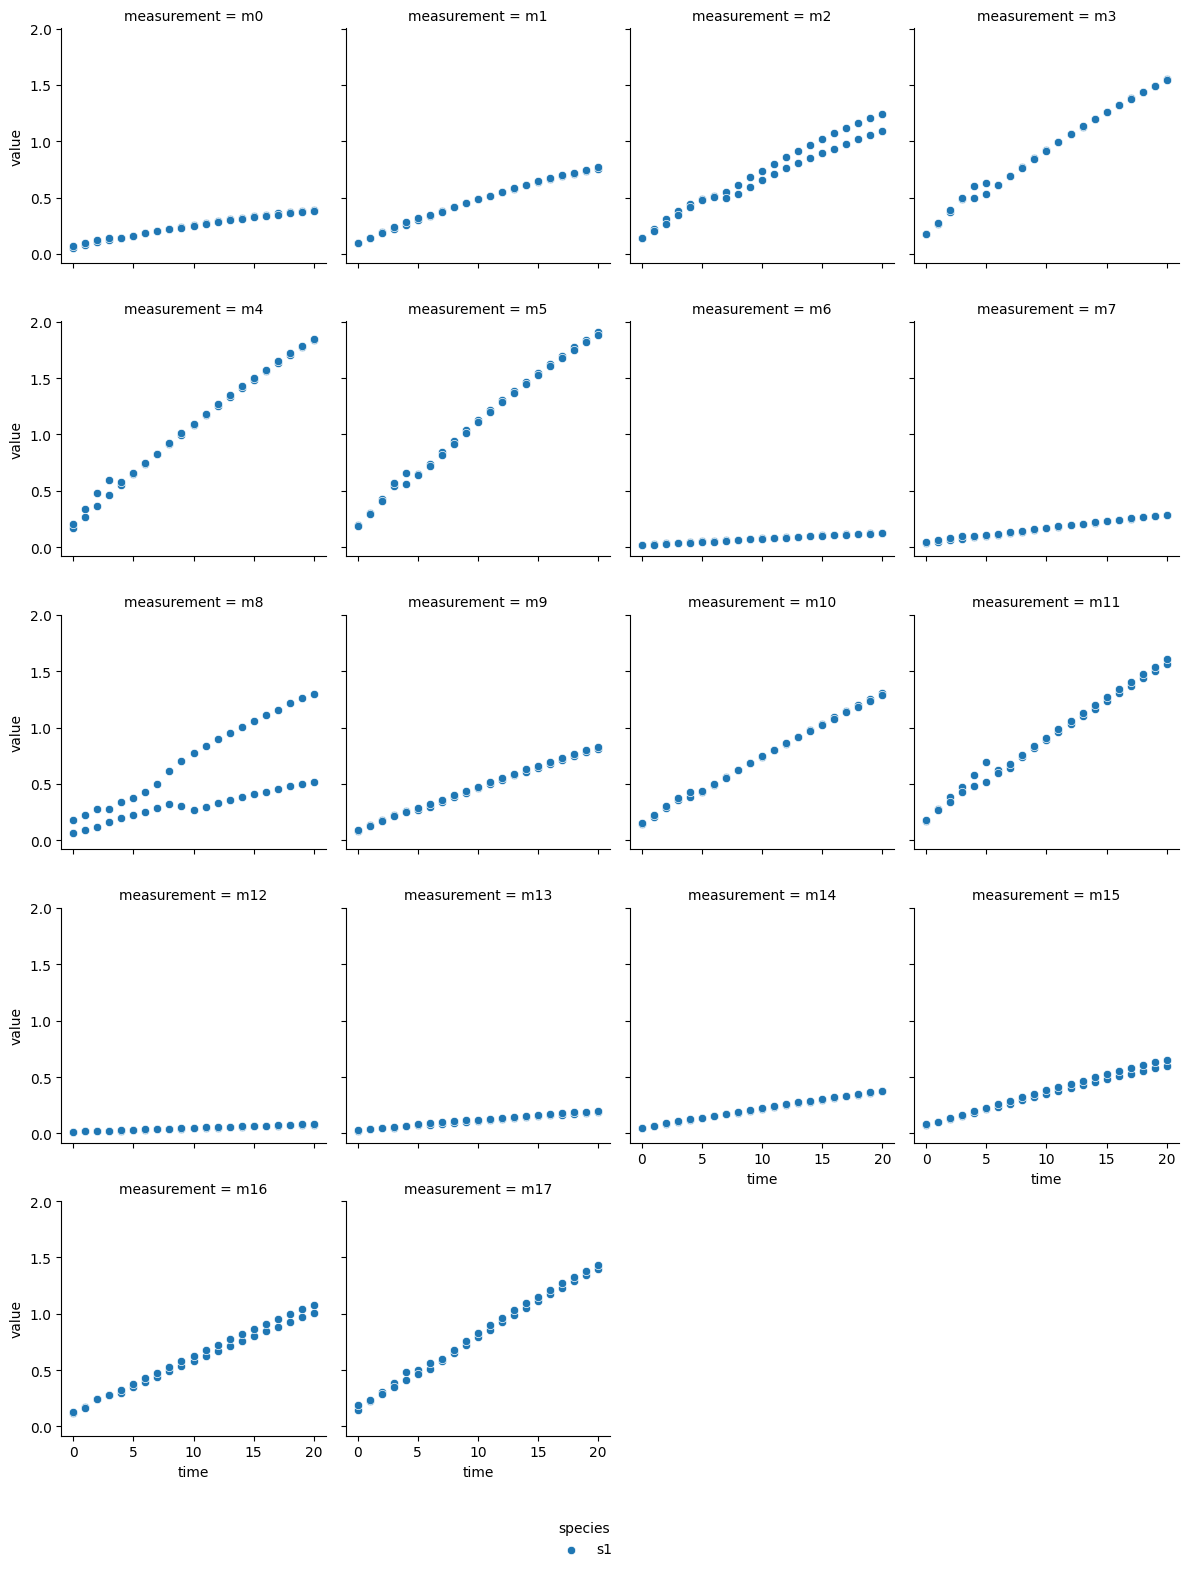

a-glucosidase inhibition by fucoidan from E. maxima


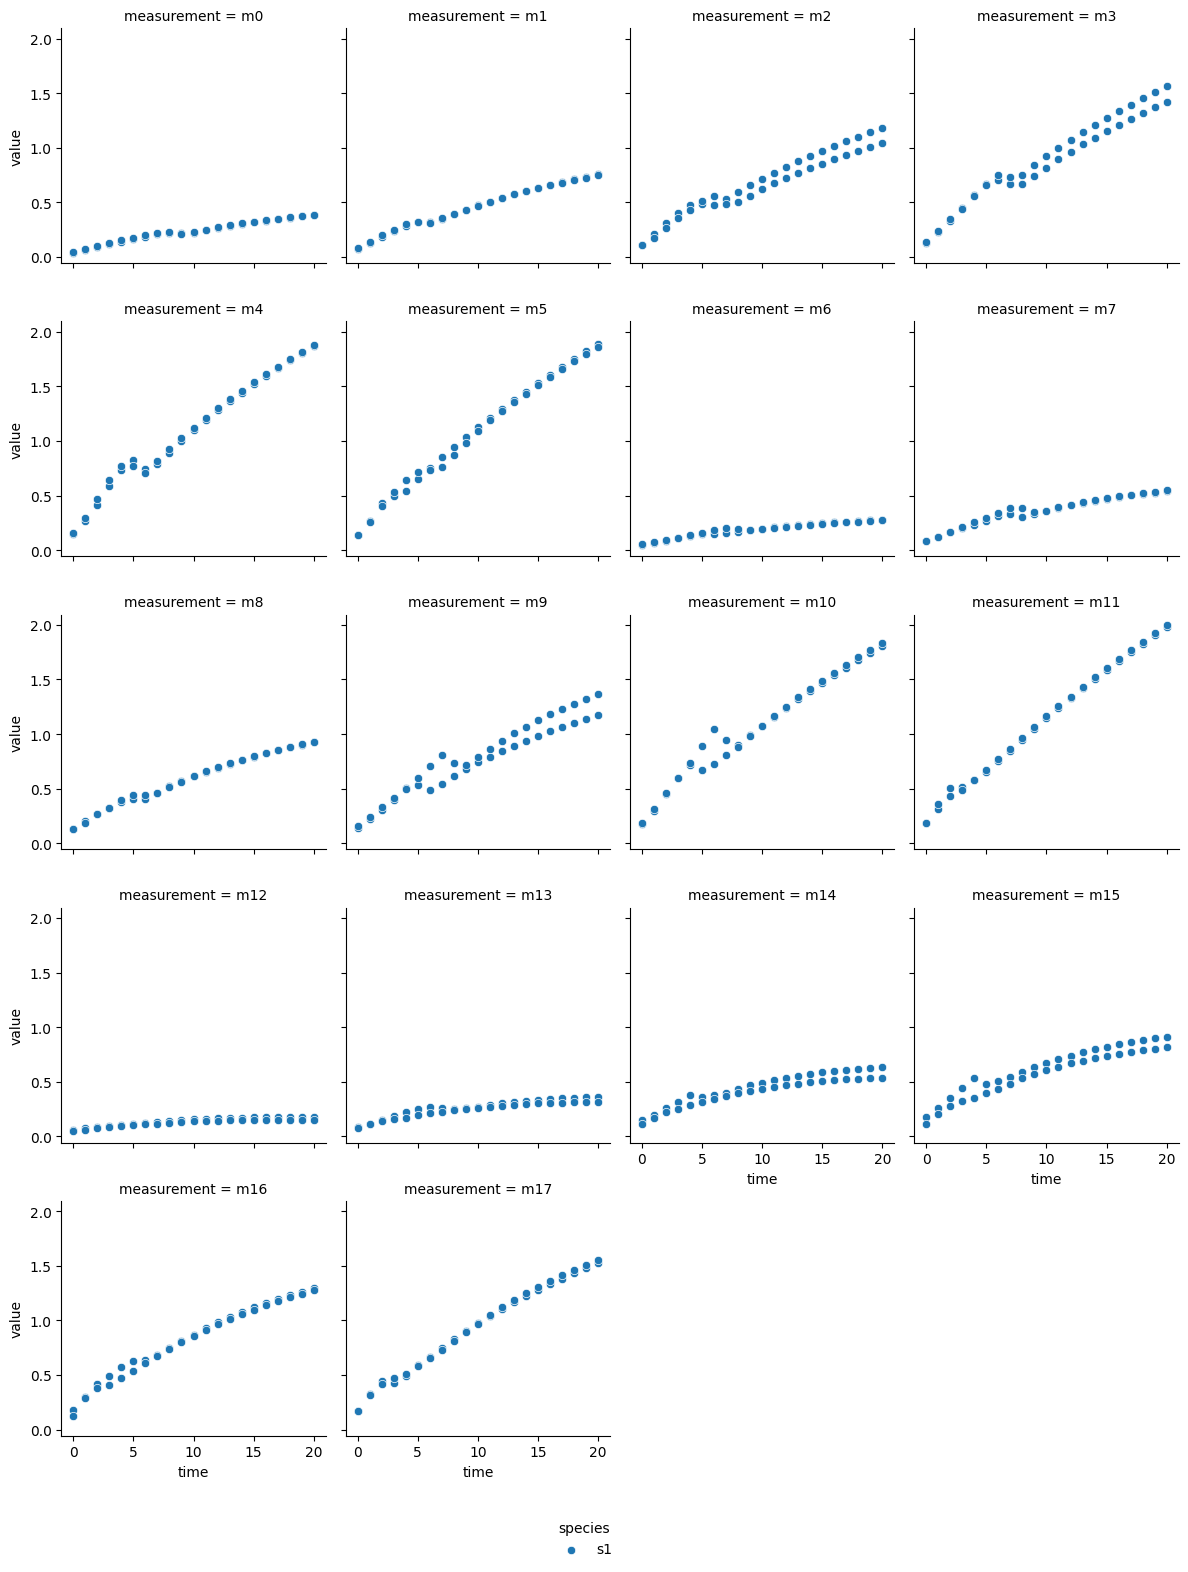

a-glucosidase inhibition by fucoidan from E. radiata


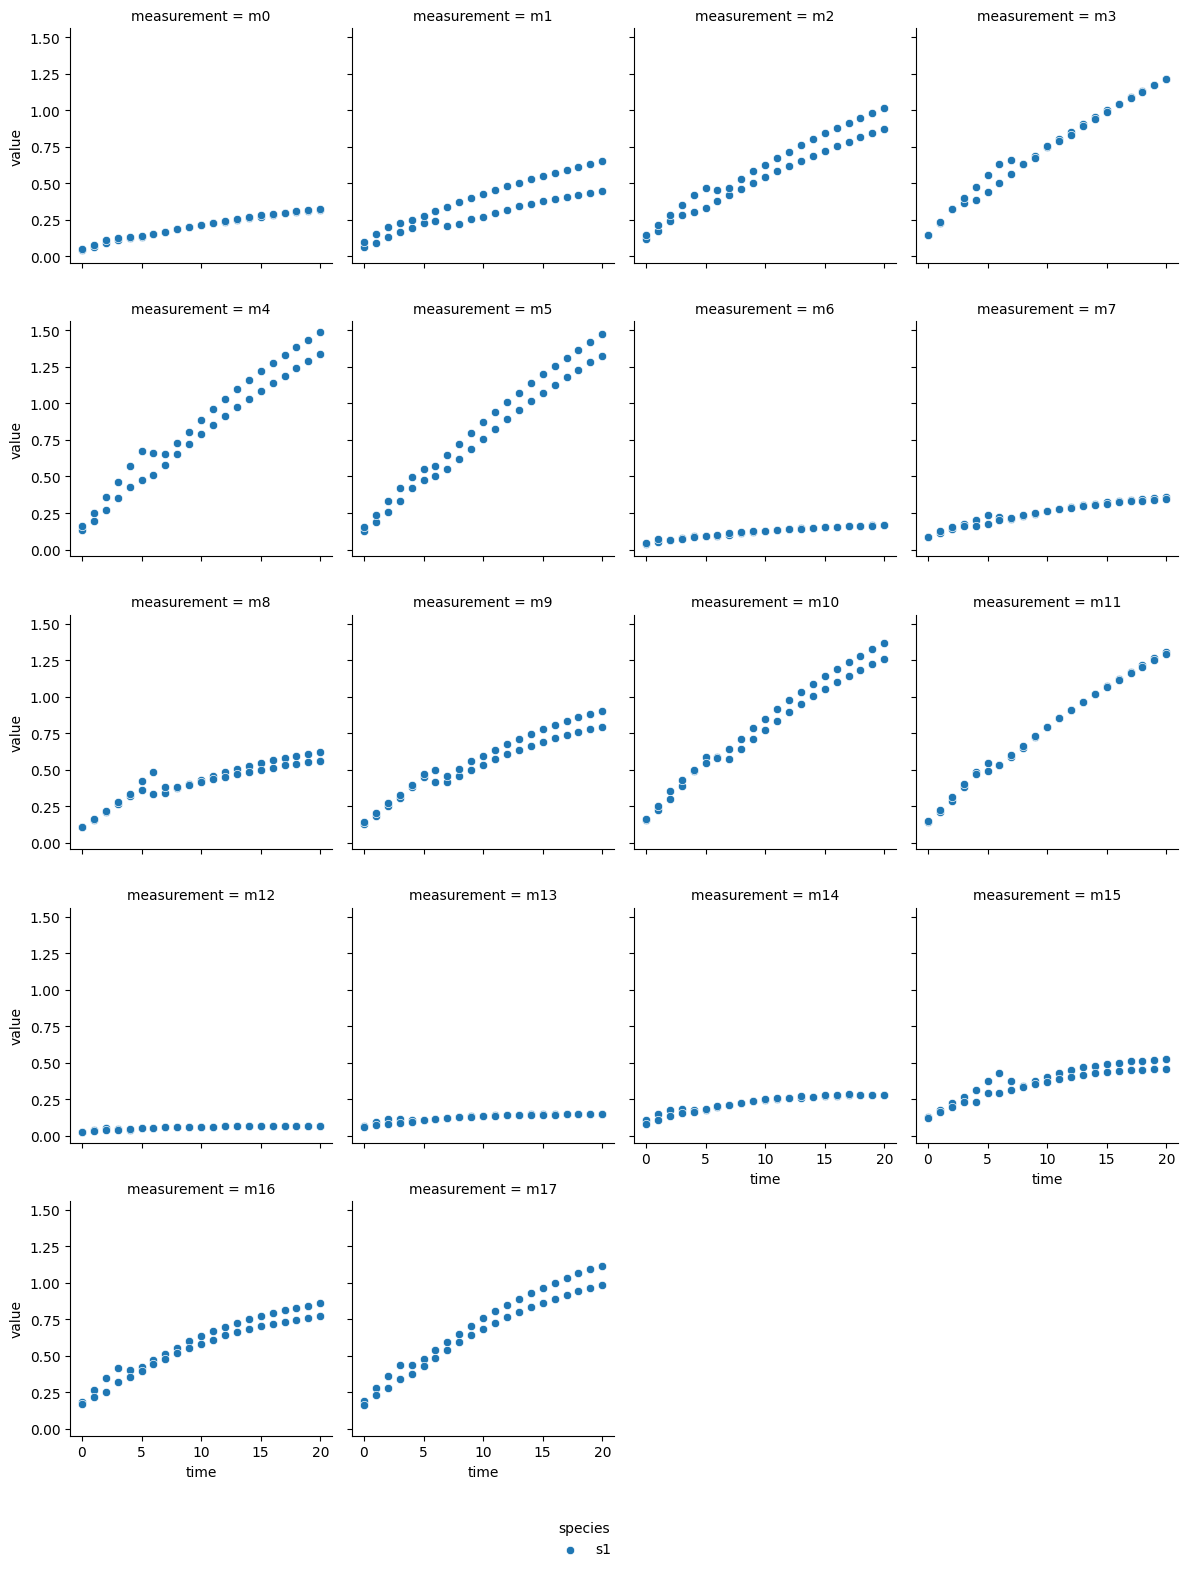

a-glucosidase inhibition by fucoidan from F. versiculosus


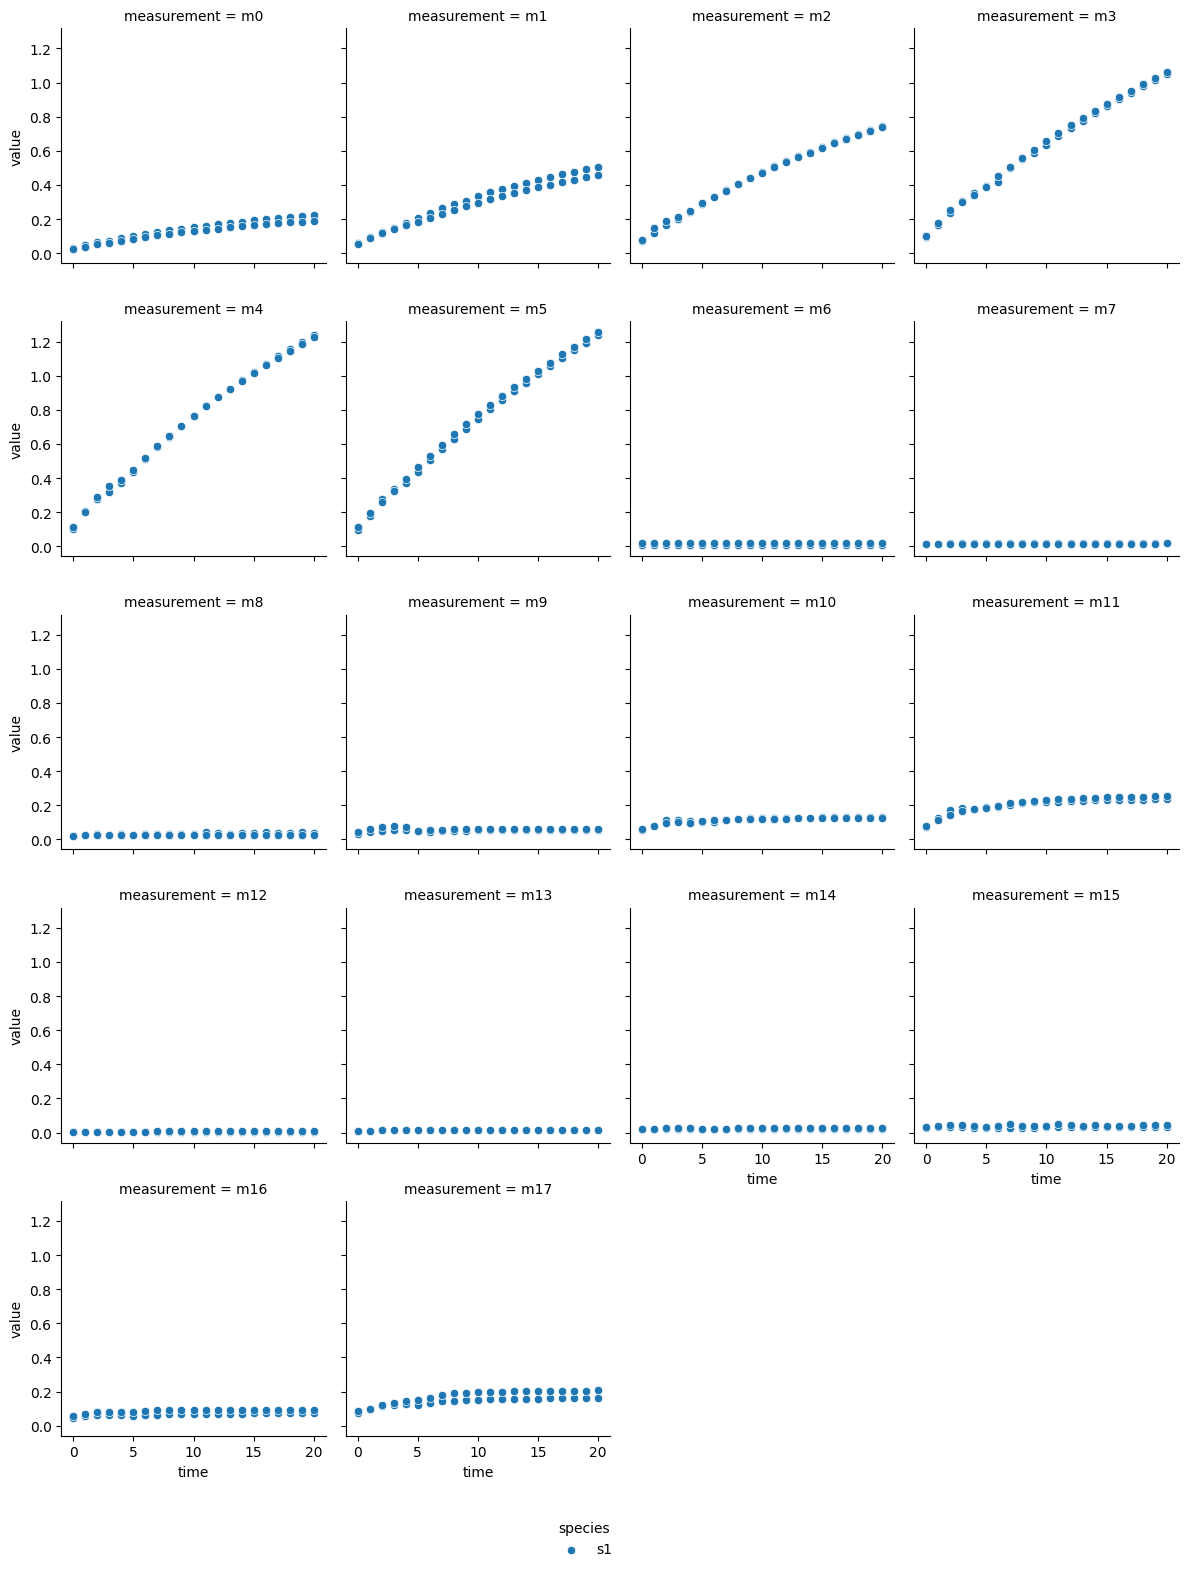

a-glucosidase inhibition by fucoidan from S. elegans


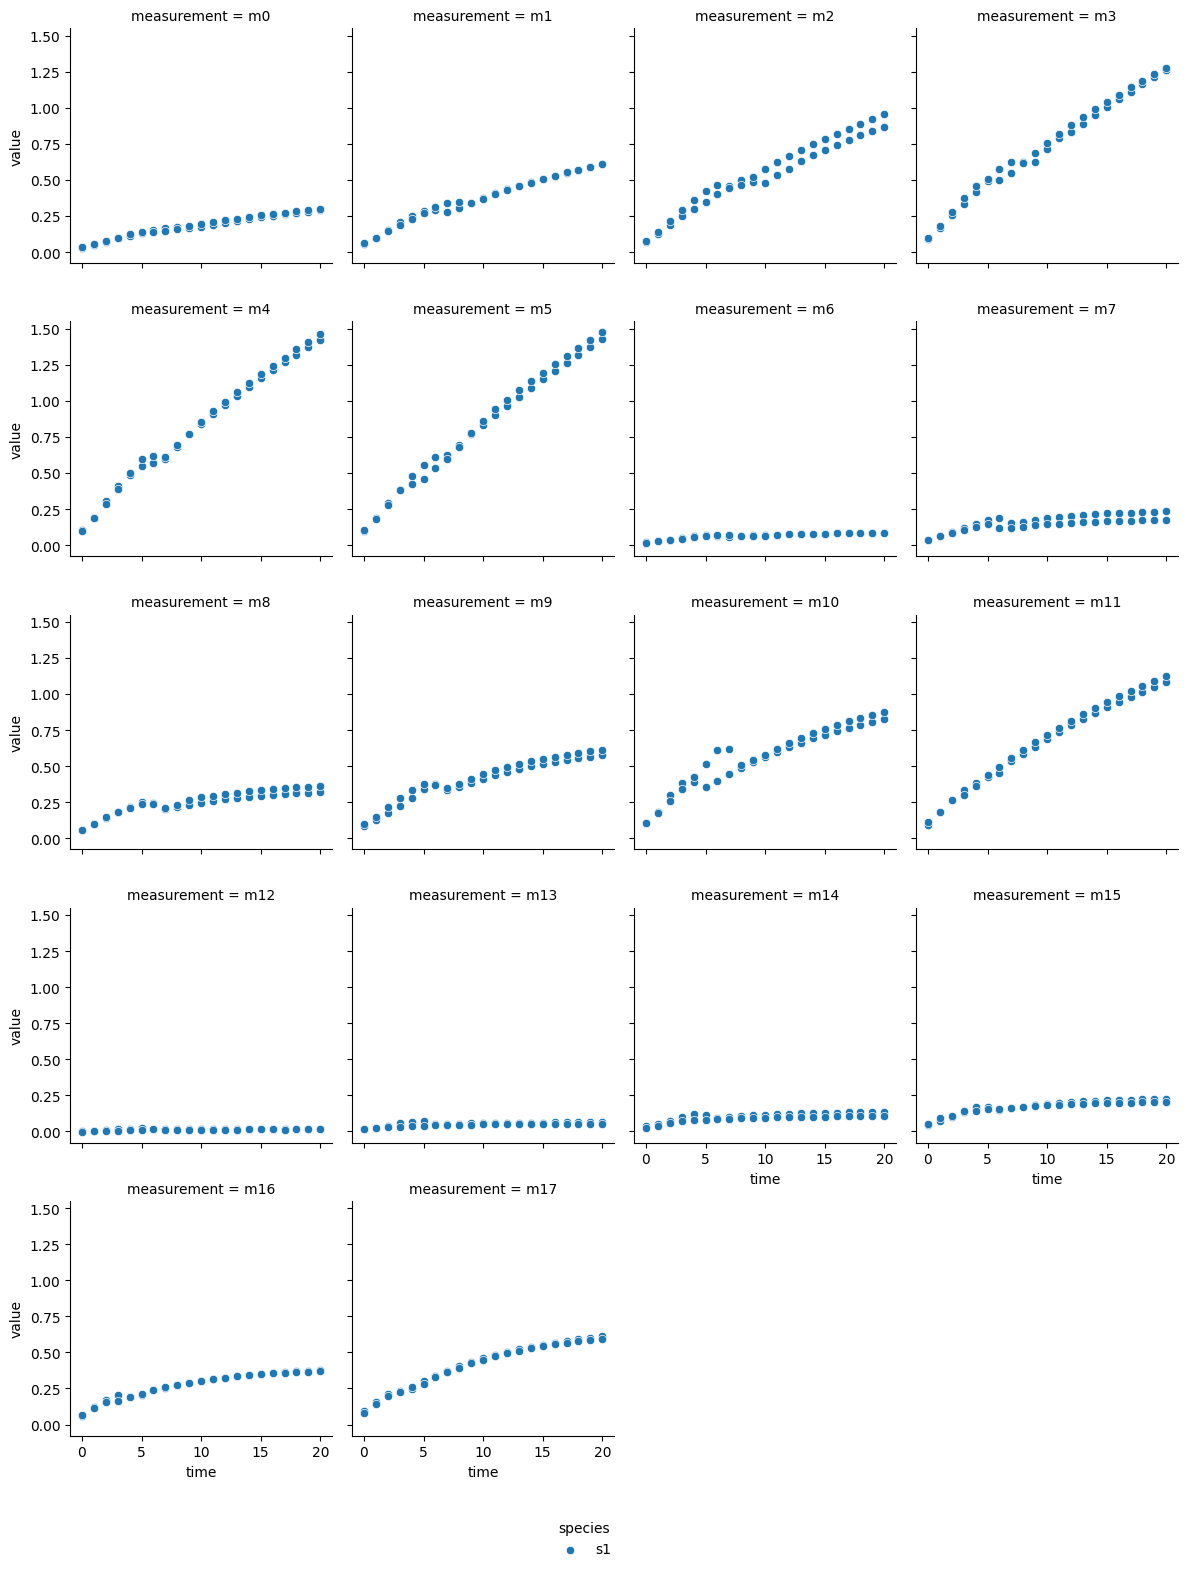

In [4]:
for doc in enzml_docs:
    print(doc.name)
    doc.visualize()
    plt.show()

The technical output of the cell above visualizes the blanked product absorbance data of each dataset. Therein, the individual measurements are labeled from m0 - m17, which represent individual experimental conditions. Thereby, measurements m0 - m5 are from reactions without inhibitor, m6 - m11 reactions with the lower inhibitor concentration, and m12 - m17 originate from reactions with the higher inhibitor concentration. Each subplot contains the data of two experimental repeats.  
In most reactions a local maximum around minute 5 occurs, which presumably sources from the analytic device. Furthermore, the repeats of m8 of the 'a-glucosidase inhibition by acarbose' dataset diverged. Therefore, this particular measurement was excluded for kinetic parameter estimation.

### Concentration calculation

Standard data of p-NP was loaded from an excel file, and a standard curve was created. Then, the standard curve was applied to the EnzymeML documents.

Calibration data was automatically blanked.


,AIC
3rd polynominal,-135
Quadratic,-135
Rational,-135
Linear,-125
Exponential,-11


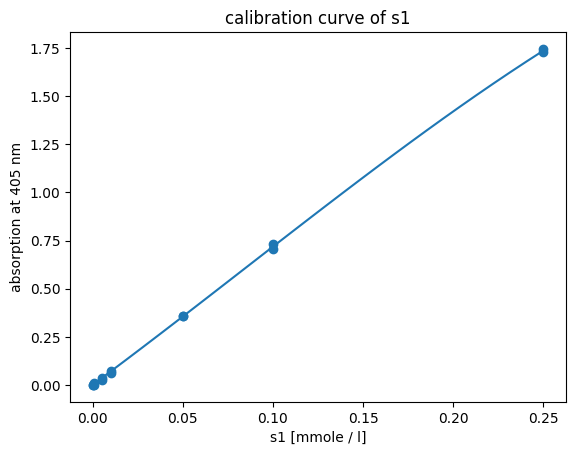

In [5]:
path_calibration_data = "../../data/glucosidase_inhibition/p-NP_standard.xlsx"


product_standard = StandardCurve.from_excel(
    path=path_calibration_data,
    reactant_id="s1", 
    sheet_name="csv", 
    wavelength=405, 
    concentration_unit = "mmole / l", 
    cutoff_absorption=2)

product_standard.visualize()

# Apply calibration curves to absorption EnzymeML documents
for enzmldoc in enzml_docs:
    product_standard.apply_to_EnzymeML(enzmldoc, "s1")

### Parameter estimation

Parameter estimation was perfomed with EnzymePynetics. Thereby, each data set was fitted to competitive, uncompetitive, and non-competitive inhibition models.

Fitting data to:
 - irreversible Michaelis Menten model
 - competitive inhibition model
 - uncompetitive inhibition model
 - non-competitive inhibition model
 - partially competitive inhibition model


,AIC,kcat [1/min],Km [mmole / l],kcat / Km [1/min * 1/mmole / l],Ki competitive [g / l],Ki uncompetitive [g / l]
non-competitive inhibition,-1785,1.982 +/- 2.02%,0.367 +/- 7.53%,5.407 +/- 7.79%,0.147 +/- 11.19%,2.908 +/- 25.18%
competitive inhibition,-1771,1.932 +/- 1.99%,0.340 +/- 7.79%,5.674 +/- 8.04%,0.107 +/- 7.75%,-
partially competitive inhibition,-1768,1.932 +/- 2.01%,0.340 +/- 7.83%,5.677 +/- 8.09%,0.104 +/- 9.33%,32.360 +/- 229.38%
uncompetitive inhibition,-1608,2.236 +/- 4.13%,0.712 +/- 11.64%,3.141 +/- 12.35%,-,0.584 +/- 9.66%
irreversible Michaelis Menten,-1465,1.588 +/- 6.28%,0.767 +/- 18.99%,2.070 +/- 20.00%,-,-


Fit report for non-competitive inhibition model
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 144
    # variables        = 4
    chi-square         = 5.6247e-04
    reduced chi-square = 4.0177e-06
    Akaike info crit   = -1785.22934
    Bayesian info crit = -1773.35009
[[Variables]]
    k_cat:  1.98169019 +/- 0.04004003 (2.02%) (init = 2.411061)
    Km:     0.36651476 +/- 0.02758671 (7.53%) (init = 1.108024)
    K_iu:   2.90802490 +/- 0.73226125 (25.18%) (init = 0.1)
    K_ic:   0.14738883 +/- 0.01649237 (11.19%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, Km)   = 0.776
    C(K_iu, K_ic)  = -0.708
    C(Km, K_ic)    = 0.651
    C(k_cat, K_ic) = 0.412
    C(k_cat, K_iu) = -0.411
    C(Km, K_iu)    = -0.325


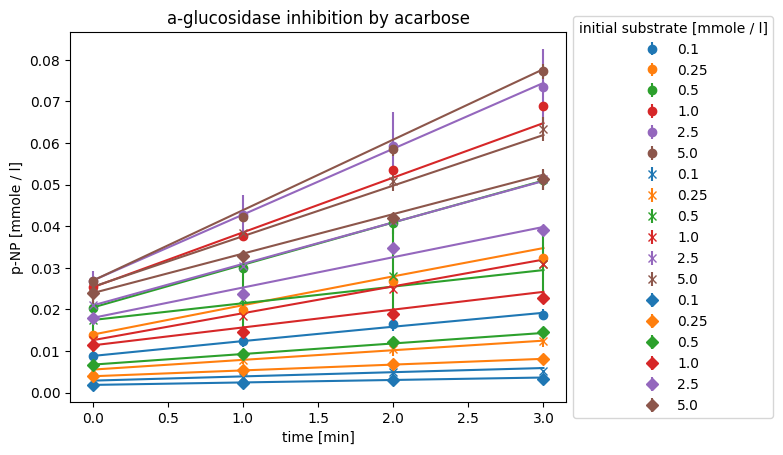

Fitting data to:
 - irreversible Michaelis Menten model
 - competitive inhibition model
 - uncompetitive inhibition model
 - non-competitive inhibition model
 - partially competitive inhibition model


,AIC,kcat [1/min],Km [mmole / l],kcat / Km [1/min * 1/mmole / l],Ki competitive [g / l],Ki uncompetitive [g / l]
non-competitive inhibition,-1641,2.313 +/- 2.76%,0.375 +/- 10.35%,6.169 +/- 10.71%,0.958 +/- 25.23%,6.179 +/- 36.15%
competitive inhibition,-1634,2.187 +/- 2.09%,0.319 +/- 9.52%,6.866 +/- 9.74%,0.627 +/- 16.40%,-
partially competitive inhibition,-1631,2.188 +/- 2.12%,0.318 +/- 9.51%,6.871 +/- 9.74%,0.582 +/- 33.85%,19.364 +/- 416.78%
uncompetitive inhibition,-1614,2.477 +/- 2.96%,0.551 +/- 7.95%,4.499 +/- 8.48%,-,2.646 +/- 15.04%
irreversible Michaelis Menten,-1565,2.141 +/- 2.66%,0.497 +/- 9.09%,4.308 +/- 9.47%,-,-


Fit report for non-competitive inhibition model
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 99
    # data points      = 144
    # variables        = 4
    chi-square         = 0.00153396
    reduced chi-square = 1.0957e-05
    Akaike info crit   = -1640.75884
    Bayesian info crit = -1628.87959
[[Variables]]
    k_cat:  2.31309780 +/- 0.06385039 (2.76%) (init = 2.602635)
    Km:     0.37496408 +/- 0.03879994 (10.35%) (init = 1.196064)
    K_iu:   6.17904899 +/- 2.23363609 (36.15%) (init = 0.1)
    K_ic:   0.95780114 +/- 0.24167243 (25.23%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, Km)   = 0.776
    C(Km, K_ic)    = 0.743
    C(k_cat, K_iu) = -0.686
    C(K_iu, K_ic)  = -0.646
    C(Km, K_iu)    = -0.539
    C(k_cat, K_ic) = 0.473


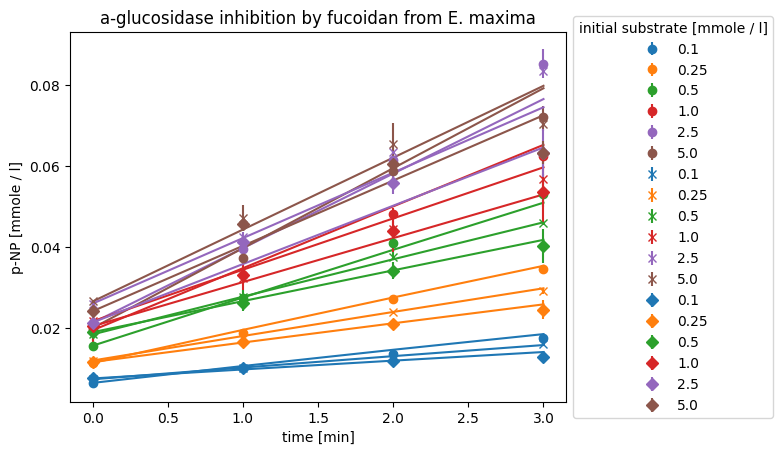

Fitting data to:
 - irreversible Michaelis Menten model
 - competitive inhibition model
 - uncompetitive inhibition model
 - non-competitive inhibition model
 - partially competitive inhibition model


,AIC,kcat [1/min],Km [mmole / l],kcat / Km [1/min * 1/mmole / l],Ki competitive [g / l],Ki uncompetitive [g / l]
competitive inhibition,-1733,1.376 +/- 2.18%,0.207 +/- 11.04%,6.639 +/- 11.26%,0.031 +/- 14.81%,-
non-competitive inhibition,-1733,1.405 +/- 2.78%,0.221 +/- 12.20%,6.352 +/- 12.51%,0.035 +/- 19.37%,1.379 +/- 82.39%
partially competitive inhibition,-1731,1.376 +/- 2.20%,0.207 +/- 11.12%,6.635 +/- 11.33%,0.030 +/- 15.53%,9.843 +/- 447.54%
uncompetitive inhibition,-1661,1.552 +/- 3.69%,0.435 +/- 10.58%,3.567 +/- 11.21%,-,0.213 +/- 16.46%
irreversible Michaelis Menten,-1616,1.324 +/- 3.34%,0.416 +/- 11.89%,3.179 +/- 12.35%,-,-


Fit report for competitive inhibition model
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 144
    # variables        = 3
    chi-square         = 8.1887e-04
    reduced chi-square = 5.8076e-06
    Akaike info crit   = -1733.14459
    Bayesian info crit = -1724.23515
[[Variables]]
    k_cat:  1.37558968 +/- 0.03004785 (2.18%) (init = 1.647308)
    Km:     0.20720665 +/- 0.02288571 (11.04%) (init = 0.7570348)
    K_ic:   0.03058514 +/- 0.00453009 (14.81%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(Km, K_ic)    = 0.721
    C(k_cat, Km)   = 0.632
    C(k_cat, K_ic) = 0.129


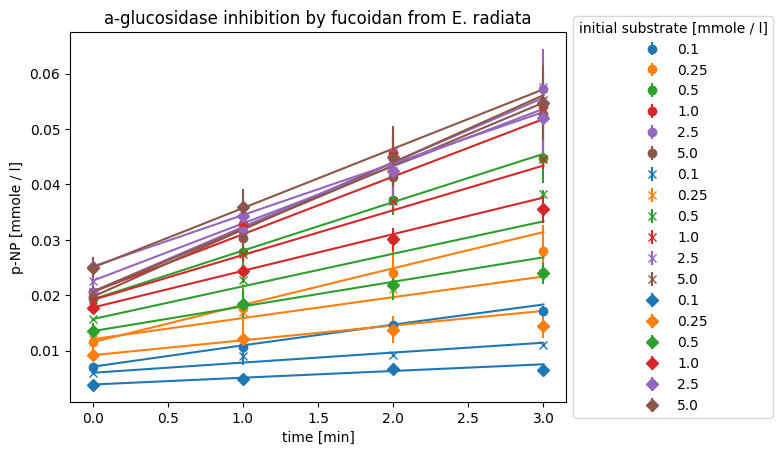

Fitting data to:
 - irreversible Michaelis Menten model
 - competitive inhibition model
 - uncompetitive inhibition model
 - non-competitive inhibition model
 - partially competitive inhibition model


,AIC,kcat [1/min],Km [mmole / l],kcat / Km [1/min * 1/mmole / l],Ki competitive [g / l],Ki uncompetitive [g / l]
competitive inhibition,-1937,1.376 +/- 1.77%,0.402 +/- 6.43%,3.422 +/- 6.67%,0.002 +/- 7.01%,-
non-competitive inhibition,-1935,1.376 +/- 1.78%,0.402 +/- 6.44%,3.424 +/- 6.69%,0.002 +/- 8.25%,427.293 +/- 90505.38%
partially competitive inhibition,-1935,1.375 +/- 1.81%,0.401 +/- 6.49%,3.426 +/- 6.74%,0.002 +/- 9.53%,511.867 +/- 18147.83%
uncompetitive inhibition,-1750,1.399 +/- 3.49%,0.445 +/- 12.18%,3.142 +/- 12.67%,-,0.010 +/- 11.08%
irreversible Michaelis Menten,-1462,0.776 +/- 14.00%,0.882 +/- 40.70%,0.880 +/- 43.04%,-,-


Fit report for competitive inhibition model
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 144
    # variables        = 3
    chi-square         = 1.9821e-04
    reduced chi-square = 1.4058e-06
    Akaike info crit   = -1937.42133
    Bayesian info crit = -1928.51189
[[Variables]]
    k_cat:  1.37607564 +/- 0.02440487 (1.77%) (init = 1.594832)
    Km:     0.40207972 +/- 0.02584226 (6.43%) (init = 0.7329193)
    K_ic:   0.00237564 +/- 1.6650e-04 (7.01%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, Km)   = 0.781
    C(Km, K_ic)    = 0.675
    C(k_cat, K_ic) = 0.388


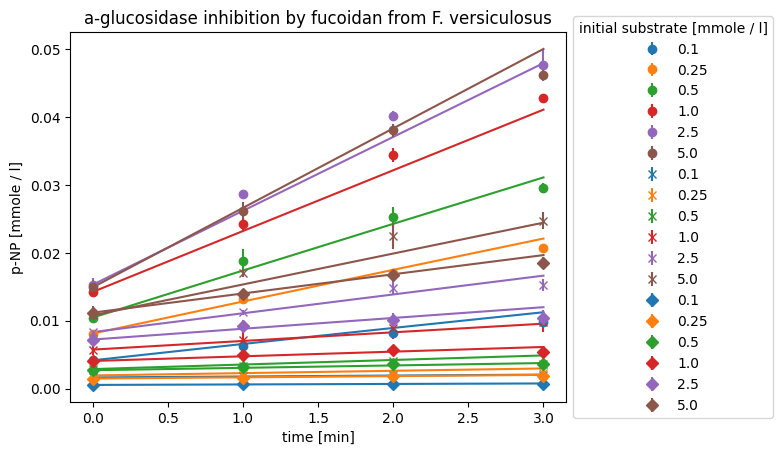

Fitting data to:
 - irreversible Michaelis Menten model
 - competitive inhibition model
 - uncompetitive inhibition model
 - non-competitive inhibition model
 - partially competitive inhibition model


,AIC,kcat [1/min],Km [mmole / l],kcat / Km [1/min * 1/mmole / l],Ki competitive [g / l],Ki uncompetitive [g / l]
non-competitive inhibition,-1765,1.601 +/- 2.43%,0.282 +/- 9.75%,5.673 +/- 10.05%,0.026 +/- 15.99%,0.194 +/- 16.62%
competitive inhibition,-1722,1.485 +/- 2.52%,0.226 +/- 11.46%,6.583 +/- 11.73%,0.013 +/- 12.16%,-
partially competitive inhibition,-1720,1.486 +/- 2.53%,0.226 +/- 11.48%,6.573 +/- 11.76%,0.013 +/- 12.39%,72.364 +/- 133.02%
uncompetitive inhibition,-1665,1.759 +/- 3.60%,0.504 +/- 10.81%,3.493 +/- 11.40%,-,0.080 +/- 9.66%
irreversible Michaelis Menten,-1526,1.281 +/- 5.04%,0.490 +/- 17.15%,2.611 +/- 17.87%,-,-


Fit report for non-competitive inhibition model
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 144
    # variables        = 4
    chi-square         = 6.4922e-04
    reduced chi-square = 4.6373e-06
    Akaike info crit   = -1764.57602
    Bayesian info crit = -1752.69676
[[Variables]]
    k_cat:  1.60131845 +/- 0.03887413 (2.43%) (init = 1.806958)
    Km:     0.28224996 +/- 0.02752526 (9.75%) (init = 0.8304036)
    K_iu:   0.19422116 +/- 0.03227462 (16.62%) (init = 0.1)
    K_ic:   0.02569416 +/- 0.00410735 (15.99%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, Km)   = 0.755
    C(Km, K_ic)    = 0.685
    C(K_iu, K_ic)  = -0.648
    C(k_cat, K_iu) = -0.544
    C(k_cat, K_ic) = 0.422
    C(Km, K_iu)    = -0.417


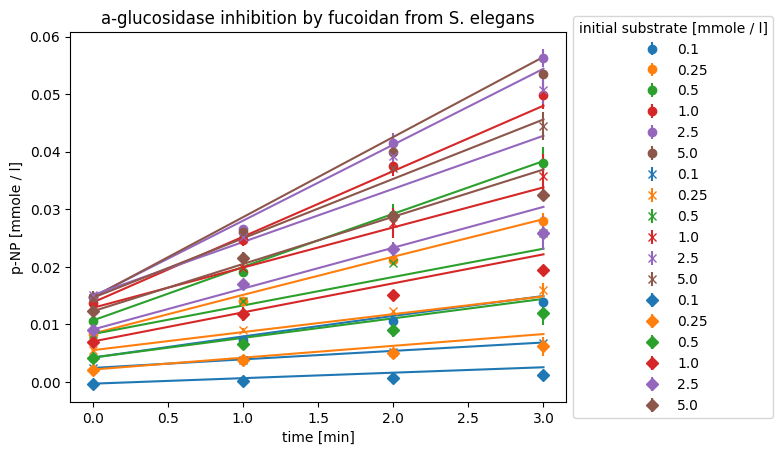

In [7]:
kinetics = []
for enzmldoc in enzml_docs:
    result = ParameterEstimator.from_EnzymeML(enzmldoc=enzmldoc, reactant_id="s1", inhibitor_id="s2", measured_species="product")
    result.fit_models(enzyme_inactivation=False, stop_time_index=4)
    kinetics.append(result)
    result.visualize(plot_means=True)
    plt.show()

## $k_{cat}$ and $K_{m}$



In [8]:
# Get kinetic parameters of all datasets
kcat = []
kcat_std = []
Km = []
Km_std = []
corr_kcat_km = []
for result in kinetics:
    params = result.get_parameter_dict()

    kcat.append(params["k_cat"].value)
    kcat_std.append(params["k_cat"].stderr)

    Km.append(params["Km"].value)
    Km_std.append(params["Km"].stderr)


    correlation = params["k_cat"].correl
    if correlation == None:
        corr_kcat_km.append(float("nan"))
    else:
        corr_kcat_km.append(correlation["Km"])


df = pd.DataFrame.from_dict({
    'kcat [1/min]':kcat, 
    'kcat stderr':kcat_std, 
    'Km [mM]':Km, 
    'Km stderr':Km_std, 
    "correlation kcat/Km":corr_kcat_km})

df


,kcat [1/min],kcat stderr,Km [mM],Km stderr,correlation kcat/Km
0,1.981690,0.040040,0.366515,0.027587,0.776122
1,2.313098,0.063850,0.374964,0.038800,0.775882
2,1.375590,0.030048,0.207207,0.022886,0.631751
3,1.376076,0.024405,0.402080,0.025842,0.781263
4,1.601318,0.038874,0.282250,0.027525,0.755019


In [9]:
enzmldoc = enzml_docs[0]

del enzmldoc.measurement_dict["m6"]
del enzmldoc.measurement_dict["m7"]
del enzmldoc.measurement_dict["m8"]
del enzmldoc.measurement_dict["m9"]
del enzmldoc.measurement_dict["m10"]
del enzmldoc.measurement_dict["m11"]
del enzmldoc.measurement_dict["m12"]
del enzmldoc.measurement_dict["m13"]
del enzmldoc.measurement_dict["m14"]
del enzmldoc.measurement_dict["m15"]
del enzmldoc.measurement_dict["m16"]
del enzmldoc.measurement_dict["m17"]

In [10]:
kinetics = ParameterEstimator.from_EnzymeML(
    enzmldoc=enzmldoc,
    reactant_id="s1",
    measured_species="product")

kinetics.fit_models(enzyme_inactivation=True)

Fitting data to:
 - irreversible Michaelis Menten model
 - competitive product inhibition model
 - uncompetitive product inhibition model
 - non-competitive product inhibition model
 - substrate inhibition model


,AIC,kcat [1/min],Km [mmole / l],ki time-dep enzyme-inactiv. [1/min],kcat / Km [1/min * 1/mmole / l],Ki competitive [mmole / l],Ki uncompetitive [mmole / l]
irreversible Michaelis Menten,-2621,1.621 +/- 1.16%,0.341 +/- 1.78%,0.011 +/- 15.30%,4.754 +/- 2.13%,-,-
competitive product inhibition,-2620,1.613 +/- 1.28%,0.331 +/- 3.70%,0.009 +/- 24.17%,4.873 +/- 3.92%,1.714 +/- 112.95%,-
uncompetitive product inhibition,-2619,1.622 +/- 1.34%,0.341 +/- 2.24%,0.011 +/- 15.44%,4.750 +/- 2.61%,-,135.961 +/- 607.61%
non-competitive product inhibition,-2617,1.617 +/- 2.32%,0.332 +/- 5.83%,0.009 +/- 56.15%,4.866 +/- 6.28%,1.524 +/- 119.33%,23.605 +/- 961.26%
substrate inhibition,-1410,46.610 +/- 9.48%,110.802 +/- 3.35%,0.005 +/- 283.40%,0.421 +/- 10.06%,-,34.922 +/- 2032.75%


In [11]:
kinetics.fit_models(
    enzyme_inactivation=True, 
    start_time_index=8,
    initial_substrate_concs=[0.1, 0.25, 0.5, 1, 5])

Fitting data to:
 - irreversible Michaelis Menten model
 - competitive product inhibition model
 - uncompetitive product inhibition model
 - non-competitive product inhibition model
 - substrate inhibition model


,AIC,kcat [1/min],Km [mmole / l],ki time-dep enzyme-inactiv. [1/min],kcat / Km [1/min * 1/mmole / l],Ki competitive [mmole / l],Ki uncompetitive [mmole / l]
substrate inhibition,-1544,1.687 +/- 2.26%,0.369 +/- 3.50%,0.023 +/- 14.36%,4.570 +/- 4.16%,-,89.803 +/- 35.37%
irreversible Michaelis Menten,-1537,1.599 +/- 1.34%,0.339 +/- 2.02%,0.020 +/- 16.01%,4.713 +/- 2.42%,-,-
competitive product inhibition,-1535,1.599 +/- 1.44%,0.339 +/- 2.03%,0.020 +/- 16.65%,4.713 +/- 2.49%,999.981 +/- 395.34%,-
uncompetitive product inhibition,-1535,1.615 +/- 8.15%,0.345 +/- 12.72%,0.020 +/- 21.72%,4.686 +/- 15.11%,-,14.948 +/- 765.60%
non-competitive product inhibition,-1533,1.615 +/- 8.21%,0.345 +/- 12.80%,0.020 +/- 22.67%,4.686 +/- 15.21%,991.871 +/- 8172.15%,15.008 +/- 796.87%


Fit report for irreversible Michaelis Menten model
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 124
    # variables        = 3
    chi-square         = 4.8782e-04
    reduced chi-square = 4.0315e-06
    Akaike info crit   = -1537.28559
    Bayesian info crit = -1528.82474
[[Variables]]
    k_cat:  1.59872877 +/- 0.02146161 (1.34%) (init = 2.411061)
    Km:     0.33921445 +/- 0.00684469 (2.02%) (init = 1.108024)
    K_ie:   0.02043677 +/- 0.00327157 (16.01%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, K_ie) = 0.868
    C(Km, K_ie)    = -0.309
    C(k_cat, Km)   = 0.126


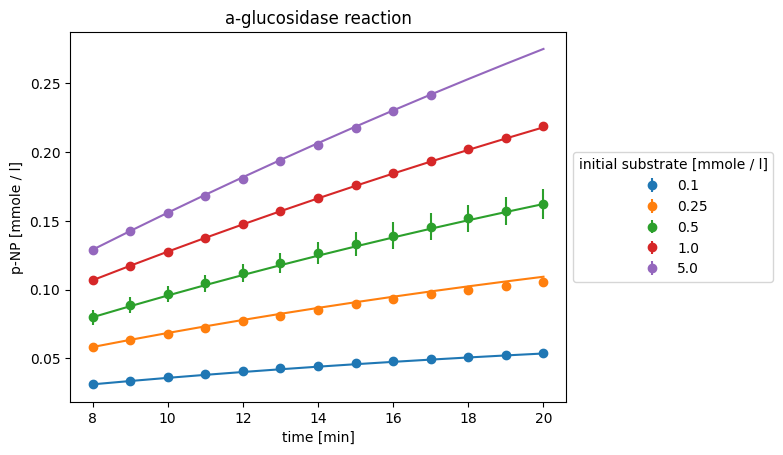

In [12]:
kinetics.visualize(model_name="irreversible Michaelis Menten", title="a-glucosidase reaction")